# Week 1: Regression
Welcome the very first Jupyter Notebook of the AI4AE course! In this notebook we will be discussing *regression*. 

You have already seen *linear* regression applied in the ADSEE-I course, and seen some of its inner workings in the Probability & Statistics course and maybe even in the Applied Numerical Analysis course too. This can be seen as an indication how important this tool is to an engineer. In fact, understanding how to model relationships within data is crucial for solving complex challenges in science and engineer. 

In this notebook, we will dive into regression a bit further as it is a powerful tool that serves as the cornerstone for many machine learning algorithms. We will cover the inner workings of linear and polynomial regression, and how they are applied in the 'real world' by using Python libraries.

For this notebook we expect you to have attended the first lecture of the AI4AE course and to be comfortable with `numpy`, `matplotlib` and `pandas`. If this is not the case, check out the notebooks collection in the `scientific-computing-essentials` directory!

## 1. Programming Linear Regression from Scratch
### Overview
Linear regression is a fundamental concept in machine learning that forms the basis for predicting a continuous target variable based on one or more independent features. At its core, linear regression aims to find the best-fit line through the data points, minimizing the difference between the predicted and actual values. This difference is also referred to as a **cost function**.

As you may remember from your early mathematics lessons in highschool, a linear line can be described in the following way:
$$y=\alpha + \beta x$$
- $y$ is the target variable
- $x$ is the input variable
- $\alpha$ is the intercept
- $\beta$ is the slope or coefficient of the line

In class, you have seen how to find the values of $\alpha$ and $\beta$ analytically. 
Try to implement the calculation of $\alpha$ and $\beta$ in Python in the function below:

In [22]:
import numpy as np

def ordinary_least_squares_method(X, y):
    # Implement your solution here.
    beta = (y.shape[0]-1)/y.shape[0]*np.cov(X, y)[1,0]/np.var(X)
    alpha = np.mean(y) - beta*np.mean(X)
    return alpha, beta

You can use the next two blocks of code to visualize your solution. The first block generates a synthetic dataset by placing data on a known line with some random noise applied to it. The second block prints the $\alpha$ and $\beta$ calcluated with your function `ordinary_least_squares_method` and then plots your linear prediction on top of the datapoints.

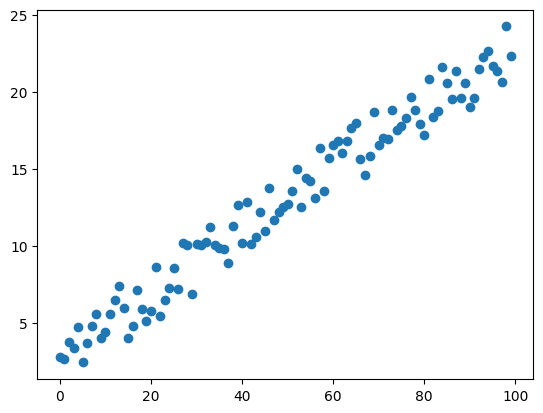

In [17]:
# Generate mock dataset
n_datapoints = 100
X = np.arange(0, n_datapoints)

# Set the coefficients
alpha_true = 3
beta_true = 0.2
noise_range = 4

# Here we create a random noise to add to the data
noise = np.random.uniform(-noise_range/2, noise_range/2, n_datapoints)
y = alpha_true + beta_true * X  + noise

# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(X, y)

49.5
12.939371512613873
3.0124860656940378 0.20054314034181484


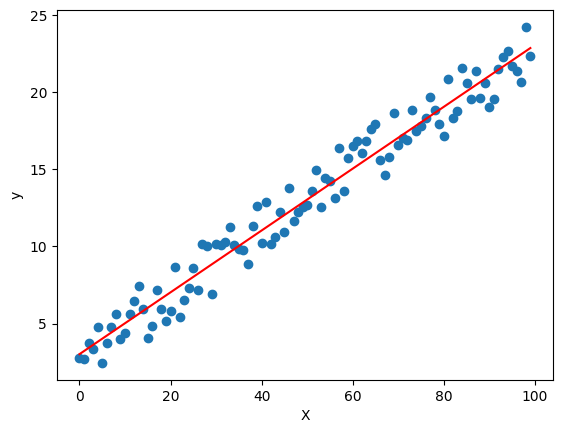

In [23]:
# Perform linear regression
print(np.mean(X))
print(np.mean(y))
alpha, beta = ordinary_least_squares_method(X, y)
print(alpha, beta)

# Visualize the regression line on the data
plt.scatter(X, y)
y_hat = alpha + beta * X
plt.plot(X, y_hat, color='red')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

Play around with the noise range, how different area $\alpha$ and $\beta$ from the true values?

## 2. Data Preprocessing
Now you have developed a function that can fit data linearly.

In the rest of this notebook we will be developing a model that predicts the noise produced from a NACA 0012 for various frequencies, angles of attack and wind tunnel speeds. We will try to predict these values using a linear regression model.

### Data Exploration
Before diving into the intricacies of modeling, it is crucial to understand the dataset. This step involves getting a sense of the overall structure of the data, gaining insights into the distribution of features, and identifying potential outliers.

In the following block, we load and explore the dataset using `pandas`.

In [24]:
import pandas as pd

# Load the data
data = pd.read_csv('data/AirfoilSelfNoise.csv')

# Show the data
data

,f,alpha,c,U_infinity,delta,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,900,0.0,0.3048,71.3,0.002663,NaN
2,1000,0.0,0.3048,71.3,0.002663,125.201
3,1250,0.0,0.3048,71.3,0.002663,125.951
4,1600,0.0,0.3048,71.3,0.002663,127.591
...,...,...,...,...,...,...
1500,2500,15.6,0.1016,39.6,0.052849,110.264
1501,3150,15.6,0.1016,39.6,0.052849,109.254
1502,4000,15.6,0.1016,39.6,0.052849,NaN
1503,5000,15.6,0.1016,39.6,0.052849,106.224


The dataset contains:
- `f` is the frequency of noise in Hz
- `alpha` is the angle of attack in deg
- `c` is the chord length in m
- `U_infinity` is the free-stream velocity
- `delta` is the suction side displacement thickness
- `SSPL` is the Scaled Sound Pressure Level

The dataset was obtained from the UCI Machine Learning Repository https://archive.ics.uci.edu/dataset/291/airfoil+self+noise.  Brooks,Thomas, Pope,D., and Marcolini,Michael. (2014). Airfoil Self-Noise. UCI Machine Learning Repository. https://doi.org/10.24432/C5VW2C.

To get a better insight on the data, we can plot, for example, the SSPL against the free-stream velocity. 

In [ ]:
plt.scatter(data['U_infinity'], data['SSPL'])
plt.xlabel('Wind tunnel speed')
plt.ylabel('SSPL')

### Data Cleaning
The next step is data cleaning. Many real life datasets are not perfect. They contain noise, outliers or missing values. 
`pandas` has a few useful functions to clean the data. 

The dataset that we have provided is already very clean as it has already been processed. However, to show how to do some of this cleaning we have altered a few values in the SSPL column.

The first step is to remove the missing values. In `pandas`, a value that is not registered is called `NaN` (Not a Number). 
In the following block, the function `isna()` is used to see how many `NaN`s there are in the SSPL column.

In [28]:
len(data['SSPL'][data['SSPL'].isna()])

8

We can see there are 8 `NaN` values in the SSPL column. 

The following block deletes all rows with `NaN`s with the function `dropna()`.

In [26]:
data_clean = data.dropna()

And once again running the previous line on this dataset shows us that the number of `NaN`s is now 0!

In [27]:
len(data_clean['SSPL'][data_clean['SSPL'].isna()])

0

### *Outliers*

We can also check for outliers using some statistics. By calculating the z-score of each point we can assess whether a datapoint is an outlier or not. To compute the z-score of the values we use the `scipy.stats` library.

The following code checks for datapoints with a z-score higher than 3:

In [29]:
from scipy import stats
z_scores = np.abs(stats.zscore(data_clean['SSPL']))
data_clean[(z_scores > 3)]

ModuleNotFoundError: No module named 'scipy'

We can indeed see that these points are outliars as a 31dB or 170dB are quite unreasonable numbers compared to the rest. We can remove them using:

In [ ]:
data_clean = data_clean[(z_scores < 3)]

Data cleaning is one of the most time intensive aspects in a real-life project. In this section, you have seen some automated tools that can be applied to filter and clean the data. However, in a real-life project, always make sure that you are aware of what datapoints you are removing and understand whether your model will still be accurate without these points.

### Train-Test-Validation Split
In machine learning, the *train-test-validation* split is a crucial step to assess the performance of a predictive model. Generally, the dataset is divided into three subsets to be used for different purposes:

- **Training Set**: This portion of the data (typically the majority, e.g., 70-80%) is used to train the model. During training, the algorithm learns the underlying patterns and relationships within the data.

- **Testing Set**: This subset (e.g., 15-20%) is kept separate from the training process and is used to evaluate the model's performance after training. The testing set provides an unbiased evaluation of the model's ability to generalize to new, unseen data.

- **Validation Set**: Sometimes, a third subset called the validation set (e.g., 10-15%) is used for fine-tuning hyperparameters and further evaluating the model's performance. A hyperparameter is a configuration setting external to a machine learning model that influences its training process but is not learned from the data. Unlike model parameters, which are learned during training, hyperparameters are set by the machine learning engineer before training and play a crucial role in determining the model's overall behavior and performance. The validation set helps ensure that the model is not overfitting to the training data and can generalize well to new, unseen data.

Splitting a training set and testing set is relatively easily done using SciKit Learn's `test_train_split()` function. You will encounter the SciKit Learn package more later on in the course as it features a great amount of tools for machine learning.

In [31]:
from sklearn.model_selection import train_test_split

# Splitting the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

While doing this split, it is important to keep an eye on *reproducibility*. 
Function `train_test_split` randomly selects entries in the dataset, which is great for any real world application.
However, when we are in a controlled environment like in academic research or in a course like this, it is required that the exact same 'random' values are used every time. This is what the `random_state` controls, as it sets a *seed* for the random engine of the function.

The following function is always used in the AI4AE course for getting the train, test and validation split in a consistent manner. This function will usually be available during lab assignments and the final exam.

In [32]:
def train_test_validation_split(X, y, test_size, cv_size):
    # collective size of test and cv sets
    test_cv_size = test_size+cv_size

    # split data into train and test - cross validation subsets
    X_train, X_testcv, y_train, y_testcv = train_test_split(
        X, y, test_size=test_cv_size, random_state=0, shuffle=True)

    # split test - cross validation sets into test and cross validation subsets
    X_test, X_cv, y_test, y_cv = train_test_split(
        X_testcv, y_testcv, test_size=cv_size/test_cv_size, random_state=0, shuffle=True)

    # return split data
    return [X_train, y_train, X_test, y_test, X_cv, y_cv]

## 3. Regression with Scikit-Learn

In a previous exercise, we have created our own linear regression implementation.
In real-life projects, however, it is recommended to use libraries as much as possible as opposed to creating your own implementation of existing algorithms.
By doing so, you make sure you always use extensively-tested and optimized state-of-the-art implementations.  

In both industry and research, one of the most popular Python packages for machine learning is Scikit-Learn (`sklearn`). 

### Linear Regression
`sklearn` is quite user friendly and simplifies the implementation of linear regression by providing a high-level interface.
In this section, you will use the `LinearRegression` class in `sklearn` to create a linear regression model.

We start by making the same mock dataset as we did above.

In [33]:
# Generate mock dataset
n_datapoints = 100
X = np.arange(0, n_datapoints)

# Set the coefficients
alpha_true = 3
beta_true = 0.2
noise_range = 4

# Here we create a random noise to add to the data
noise = np.random.uniform(-noise_range/2, noise_range/2, n_datapoints)
y = alpha_true + beta_true * X  + noise

# We split the data using
X_train, y_train, X_test, y_test, X_cv, y_cv = train_test_validation_split(X, y, 0.3, 0.2)

In order to perform linear regression with `sklearn`, we follow the steps below: 
1. Define the model
2. Train the model
3. Evaluate the model
4. Make predictions using the model

Below you can find what these steps look like:

In [34]:
# Importing necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Defining a linear regression model
model = LinearRegression()

# 2. Training the model
model.fit(X_train.reshape(-1, 1), y_train)

# 3. Evaluating the model using the test set
# To evaluate the model, we will predict a set of values using the test set
y_pred = model.predict(X_test.reshape(-1, 1))

# We will then compare the predicted values with the actual values using the mean squared error
# The lower this value, the better the model fits the data
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 4. Make prediction using the model
X_pred = 10
y_pred = model.predict([[X_pred]])
print(f'Predicted value for X = {X_pred}: {y_pred[0]}')

Mean Squared Error: 1.3365463025582227
Predicted value for X = 10: 5.187410649524539


Note that `LinearRegression` only accepts inputs in a 2D array. This is because it supports having more than just one input (something we will get to in a bit). For now this means we will need to transfer our array with inputs that look like [x1, x2, x3, x4] into an array that looks like [[x1], [x2], [x3], [x4]]. This can be easily done using the `.reshape(-1, 1)` function from Numpy. The output vector does not have to be reshaped.

We will now compare the Scikit-Learn implementation to the one we implemented above from scratch.

In [35]:
# Training the homemade model
alpha, beta = ordinary_least_squares_method(X_train, y_train)
y_pred = alpha + beta * X_test
mse = mean_squared_error(y_test, y_pred)
print(f'Homemade: Mean Squared Error = {mse}')

# Training the Scikit-Learn model
sklearn_model = LinearRegression()
sklearn_model.fit(X_train.reshape(-1, 1), y_train)
y_pred = sklearn_model.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred)
print(f'Scikit-Learn: Mean Squared Error = {mse}')

Homemade: Mean Squared Error = 1.3365463025582234
Scikit-Learn: Mean Squared Error = 1.3365463025582227


We can see that both methods lead to the same Mean Squared Error. 
The two implementations also lead to the same coefficients:

In [36]:
# Print the coefficient for our own implementation
print(f'Homemade: alpha = {alpha}, beta = {beta}')

# Print the coefficients for Scikit-Learn
alpha = sklearn_model.intercept_
beta = sklearn_model.coef_[0]
print(f'Scikit-Learn: alpha = {alpha}, beta = {beta}')

Homemade: alpha = 3.261384420424898, beta = 0.19260262290996438
Scikit-Learn: alpha = 3.2613844204248945, beta = 0.19260262290996447


### Multiple Linear Regression
The `LinearRegression` class also implements the linear regression with multiple variables.

In this case, we aim to fit the data the following multilinear equation:
$$y=\alpha + \beta_0 x_0 + \beta_1 x_1 + \cdots + \beta_n x_n$$

A nice challenge would be to write out the cost function for this and derive an analytical expression for the result of this. In this notebook, however, we will simply use the version implemented in Scikit-Learn.

Let's apply the multiple linear regression to the dataset presented in the previous section about the noise of NACA-0012 airfoils, which had multiple inputs and one output. 

Above we used `pandas` to load the dataset 
However, before we can feed the data to a linear regression model, we must first convert it from the `pandas` dataframe format to a `numpy` array. This can be done using the `.to_numpy()` function. Remember that our inputs need to be in a 2D array format, so `[[x10, x11, x12, x13],[x20, x21, x22, x23],...]`, where each inner list contains all the different inputs. For this dataset, your inputs would look like this: `[[f, alpha, c, U_infinity, delta]]`. The output will simply be a 1D array.

Check the codeblock below and see if `X_train` or `y_train` still need to be adjusted.

In [37]:
# Preprocessing the data
X = data_clean.drop('SSPL', axis=1).to_numpy()
y = data_clean['SSPL'].to_numpy()

X_train, y_train, X_test, y_test, X_cv, y_cv = train_test_validation_split(X, y, 0.2, 0.1)

We will now create the model once more and we will be following the standard steps in most machine learning projects.

In [38]:
# Importing necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Defining a linear regression model
model = LinearRegression()

# 2. Training the model
model.fit(X_train, y_train)

# 3. Evaluating the model using the test set
# To evaluate the model, we will predict a set of values using the test set
y_pred = model.predict(X_test)

# We will then compare the predicted values with the actual values using the mean squared error
# The lower this value, the better the model fits the data
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 56.66109281067497


We can see that the simple linear model already fits quite well to the dataset. 
More complex models may be able to fit the data better, however this is not bad for a linear model! 

In the codeblock below check out the intercept and coefficients like shown before.

In [40]:
# Your code here
# Print the coefficients for Scikit-Learn
alpha = model.intercept_
beta = model.coef_[0]
print(f'Scikit-Learn: alpha = {alpha}, beta = {beta}')

Scikit-Learn: alpha = 131.9105360650668, beta = -0.001235809471878277


Finally, we can create a prediction for the noise level produced by an airfoil with the following properties:

In [41]:
f = 3500
alpha = 6.7
c = 0.67
U_inifinity = 40
delta = 0.00266337

SSPL = model.predict([[f, alpha, c, U_inifinity, delta]])[0]
SSPL

106.0839434689734

Check with the dataset whether this is a realistic prediction, should it be higher or lower?

## 4. Polynomial Regression
As we have seen, linear regression can already be quite powerful. However, many relations in the real world are a little more complex than just a straight line. This is where polynomial regression can help us. While linear regression models assume a linear relationship between features and the target variable, polynomial regression allows us to capture nonlinear relationships by introducing polynomial features. In this section, we'll delve into the concept of polynomial regression and how to implement it in `sklearn`.

### Polynomial Regression Equation
Polynomial regression extends linear regression by considering polynomial terms of the input features. The model equation becomes:
$$y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \cdots + \theta_n x^n$$

One important thing to realise is that working with a polynomial regression also comes with a **hyperparameter**. Like mentioned before, this is a value set by the machine learning engineer, or you in this case. The hyperparameter in polynomial regression is the degree of the polynomial you are using!

### Polynomial Regression in Scikit-Learn
In this section, we will apply polynomial regression using `sklearn`. 
To this aim, we start with the observation that the polynomial equation above is quite similar to that of multilinear regression. However, instead of having multiple different input variables, we now have the same input variable to a given power.
These are the so-called *polynomial features*

To convert a linear regressor into a polynomial regressor, `sklearn` has the `PolynomialFeatures` class. This class can be used to generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. We can then feed this feature matrix into a linear regressor and get a linear combination of these higher degree terms. 

Just like before, we will first create a mock dataset to check the algorithm. Afterwards, we will train an actual model with polynomial regression. The code below creates a dataset following a 3rd degree polynomial.

In [42]:
# Generate mock dataset
n_datapoints = 10
X = np.arange(0, n_datapoints)

# Set the coefficients
theta0_true = 3
theta1_true = 20
theta2_true = 8.3
theta3_true = -1.2
noise_range = 20

# Here we create a random noise to add to the data
noise = np.random.uniform(-noise_range/2, noise_range/2, n_datapoints)
y = theta0_true + theta1_true * X + theta2_true * X ** 2 + theta3_true * X ** 3 + noise

In the next block, we will build the polynomial features associated with the data. 
Remember that, because we are working with a 1D input matrix, we need to convert it from a vector array to a 2D matrix using `.reshape(-1, 1)`.

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# Transform the data
poly = PolynomialFeatures(degree=3) # We set the degree of the polynomial to 3

poly_features = poly.fit_transform(X.reshape(-1, 1)) # This converts the data into the polynomial features

poly_features

array([[  1.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.],
       [  1.,   5.,  25., 125.],
       [  1.,   6.,  36., 216.],
       [  1.,   7.,  49., 343.],
       [  1.,   8.,  64., 512.],
       [  1.,   9.,  81., 729.]])

We can see that `poly_features` indeed has the form of `[[1, x, x**2, x**3]]`. We can now follow the same procedure as before with training the linear regressor:

In [44]:
from sklearn.linear_model import LinearRegression

# Defining a linear regression model
poly_reg_model = LinearRegression()

# Training the model
poly_reg_model.fit(poly_features, y)

LinearRegression()

Now that the model has been trained, we can plot our predictions:

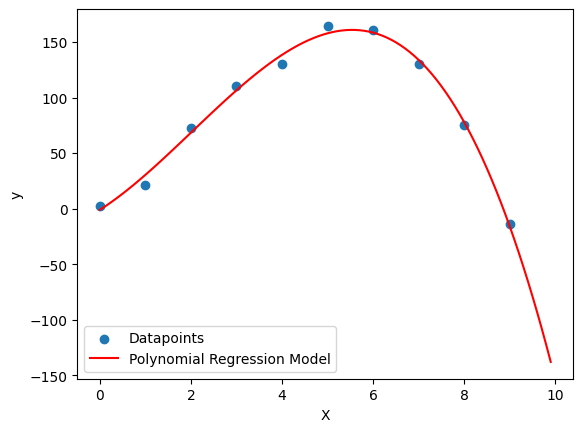

alpha: 131.9105360650668, beta: [-1.23580947e-03 -3.17289732e-01 -3.43479490e+01  1.03518493e-01
 -1.88870545e+02]


In [45]:
# Plot the dataset
plt.scatter(X, y, label='Datapoints')

# Because we only feed the model a limited amount of points, to properly visualize the polynomial, we will need to increase the resolution
X_test = np.arange(0, n_datapoints, 0.1) # Here we create 10x the amount of points to predict using the model
y_test = theta0_true + theta1_true * X_test + theta2_true * X_test ** 2 + theta3_true * X_test ** 3

# We need to transform the data we want to predict as well for the regressor to work.
poly_features_test = poly.fit_transform(X_test.reshape(-1, 1))

plt.plot(X_test, poly_reg_model.predict(poly_features_test), color='red', label='Polynomial Regression Model')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

print(f'alpha: {model.intercept_}, beta: {model.coef_}')

Congratulations, you have now created your first polynomial regressor! And as you may have seen it was very similar to creating a linear regressor. However, there is one catch! In the above example, we generated synthetic data with a polynomial of degree three. Therefore, we opted for cubic polynomial regression. But, how do we choose the polynomial when we work with a generic dataset? That's what we discuss in the following section.

## 5. Overfitting & Underfitting
Not knowing in advance what polynomial degree best fits the data, one would be inclined to think that the higher the polynomial degree the better. However, we shall see that this is not true in general. 

Consider the same dataset as before but with 2 cases, one model has a polynomial degree which is too low (`1`), and one which is too high (`15`):

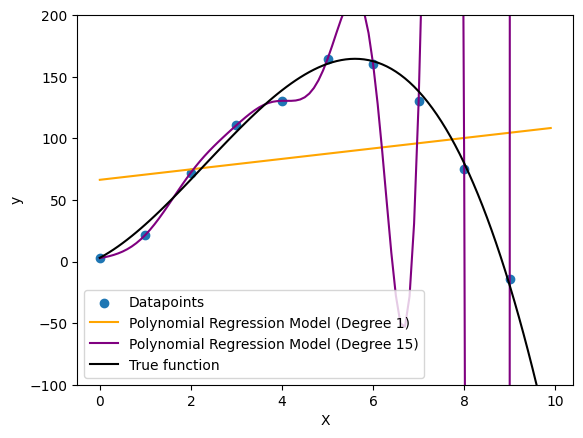

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Transform the data
poly1 = PolynomialFeatures(degree=1)
poly2 = PolynomialFeatures(degree=15)

poly_features1 = poly1.fit_transform(X.reshape(-1, 1))
poly_features2 = poly2.fit_transform(X.reshape(-1, 1))

# Defining a linear regression models
poly_reg_model1 = LinearRegression()
poly_reg_model2 = LinearRegression()

# Training the models
poly_reg_model1.fit(poly_features1, y)
poly_reg_model2.fit(poly_features2, y)

# Visualizing the models
# Because we only feed the model a limited amount of points, to properly visualize the polynomial, we will need to increase the resolution
X_test = np.arange(0, n_datapoints, 0.1) # Here we create 10x the amount of points to predict using the model
y_test = theta0_true + theta1_true * X_test + theta2_true * X_test ** 2 + theta3_true * X_test ** 3

# We need to transform the data we want to predict as well for the regressor to work.
poly_features_test1 = poly1.fit_transform(X_test.reshape(-1, 1))
poly_features_test2 = poly2.fit_transform(X_test.reshape(-1, 1))

plt.scatter(X, y, label='Datapoints')
plt.plot(X_test, poly_reg_model1.predict(poly_features_test1), color='orange', label='Polynomial Regression Model (Degree 1)')
plt.plot(X_test, poly_reg_model2.predict(poly_features_test2), color='purple', label='Polynomial Regression Model (Degree 15)')
plt.plot(X_test, y_test, color='black', label='True function')
plt.xlabel('X')
plt.ylabel('y')
plt.ylim(-100, 200)
plt.legend()
plt.show()

The plot above presents two very common phenomena in machine learning: *underfitting* and *overfitting*. Recall that our objective is to approximate the true distribution (black line) based on the available data (the blue dots).

When we use a too low polynomial degree (orange line), we observe that our model comes nowhere neear to approximating the real function.
This phenomenon is called **underfitting** and happens when our model is too simple to be able to explain the data.

The other extreme is a too high polynomial degree (purple line). In this case, we observe that our model matches the true function well only very close to the data points, while in between those points it completely deviates from the true function. This phenomenon is **overfitting** and happens when our model is too complex. In this case, we say that our model suffers from *poor generalization*, 
because it only fits well the data that was seen during training, but not *unseen* data.

To sum up:
- **Underfitting**: Occurs when a model is too simple to capture the underlying patterns in the data, leading to poor performance on both the training and testing sets.
- **Overfitting**: Occurs when a model is too complex and captures noise or random fluctuations in the training data, resulting in excellent performance on the training set but poor generalization to new, unseen data.


### Preventing over and underfitting
This is where our validation set comes into play. Up until now we have been mostly neglecting this piece of the dataset, but as you may remember, it is used to fine-tune hyperparameters. In the following codeblock we will create a more complex underlying function (of degree 5). We will then fit polynomials from degree 1 up to degree 50 to see how they do. We use the cross validation set to check their accuracy with the Mean Square Error test.

Try going through the code to see what is done and then look at the resulting plots.

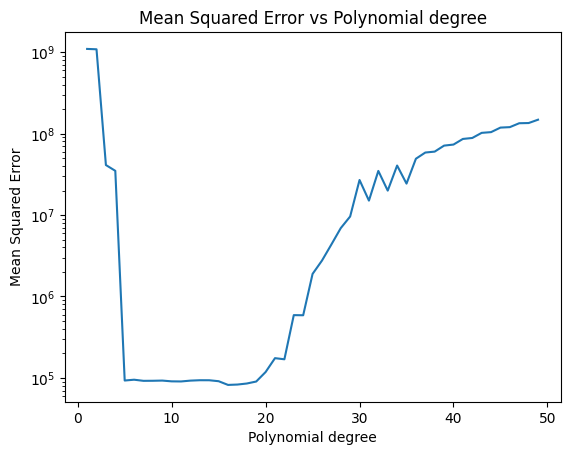

Minimum MSE at degree 16
Degree: 40, MSE: 73295605.77244626


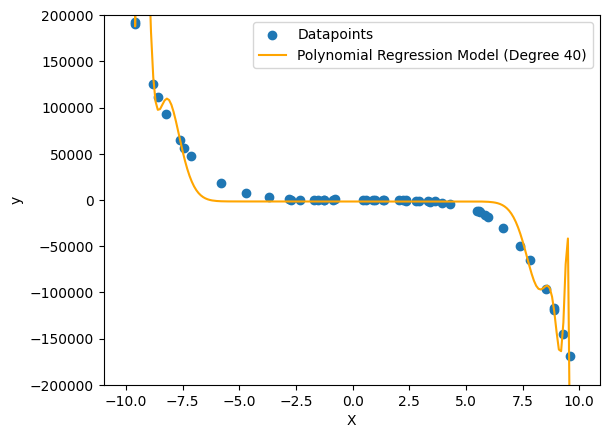

In [58]:
np.random.seed(0)
# Generating mock dataset
n_datapoints = 50
X = np.random.uniform(-10, 10, n_datapoints)

# Set the coefficients
theta0_true = 0.5
theta1_true = 1
theta2_true = 10
theta3_true = -20
theta4_true = 1
theta5_true = -2
noise_range = 1000

# Here we create a random noise to add to the data
noise = np.random.uniform(-noise_range/2, noise_range/2, n_datapoints)
y = theta0_true + theta1_true * X + theta2_true * X ** 2 + theta3_true * X ** 3 + theta4_true * X ** 4 + theta5_true * X ** 5 + noise

# Splitting the data into training and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=0)

# Creating arrays to store relevant data
degree_list = np.arange(1, 50)
poly_list = np.zeros(len(degree_list), dtype=object)
model_list = np.zeros(len(degree_list), dtype=object)
mse_list = np.zeros(len(degree_list))

# Loop through training various polynomial regression models
for degree in degree_list:
    # Convert to polynomial features
    poly = PolynomialFeatures(degree=degree)
    poly_list[degree-1] = poly
    poly_features = poly.fit_transform(X.reshape(-1, 1))

    # Train the model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y)
    model_list[degree-1] = poly_reg_model

    # Predict using the cross validation set
    poly_features_cv = poly.fit_transform(X_cv.reshape(-1, 1))
    y_pred = poly_reg_model.predict(poly_features_cv)

    # Calculate the mean squared error
    mse = mean_squared_error(y_cv, y_pred)
    mse_list[degree-1] = mse

# Visualize the mean squared error
plt.plot(degree_list, mse_list)
plt.yscale('log')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Polynomial degree')
plt.show()

# Visualize a model
degree = 40 # Feel free to change this value to see the effect of the degree on the model

print(f'Minimum MSE at degree {degree_list[np.argmin(mse_list)]}')

plt.scatter(X, y, label='Datapoints')
X_show = np.arange(-10, 10, 0.1)
print(f'Degree: {degree}, MSE: {mse_list[degree-1]}')
plt.plot(X_show, model_list[degree-1].predict(poly_list[degree-1].fit_transform(X_show.reshape(-1, 1))), color='orange', label=f'Polynomial Regression Model (Degree {degree})')
plt.ylim(-200000, 200000)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

These two plots tell us a lot about how training of more complex models works. On the first plot we can see that under a degree of 5, the model is really bad at predicting due to underfitting. Then for a range up to around degree 18, the model is very well able to fit to the underlying function. The minimum MSE is reached at a degree of 16.

Then after degree 18, the model starts rapidly increasing in error again. This is due to overfitting. In the second plot we can see what happens to the model now it overfits. We can see it starts to miss points. 

Feel free to play with various degrees of the second model as the degree can easily be changed in the codeblock. 

What value for the polynomial would be best to pick? And why?

### The Bias-Variance Tradeoff
The bias-variance tradeoff is a fundamental concept in machine learning that involves finding the right balance between two types of errors: bias and variance.

**Bias** refers to the error introduced by approximating a real-world problem (which may be complex), by a simplified model.
High bias can lead to **underfitting**, where the model is too simple and unable to capture the underlying patterns in the data.
Models with high bias may not perform well on both the training and test data, as they fail to represent the complexity of the underlying relationships.

**Variance** refers to the model's sensitivity to small fluctuations in the training data.
High variance can lead to overfitting, where the model fits the training data too closely, capturing noise and random fluctuations.
Models with high variance may perform very well on the training data but poorly on new, unseen data because they have essentially memorized the training set rather than learning the underlying patterns.

The bias-variance tradeoff arises because decreasing bias often increases variance, and vice versa. The goal is to find a model that **generalizes** well to new, unseen data. Here are a few key points:

### How to find generalizing model?
The easiest way to achieve this is to adjust the complexity of the model based on the characteristics of the data.
For complex data, use more sophisticated models; for simpler data, use simpler models.

By using **cross-validation**, you can quantify how well a model generalizes on unseen data. And thus see which models perform best. We have already applied that in the previous example.

Another method for preventing overfitting is **regularization**. Regularization adds a penalty to the cost function for overly complex models. The two most common type of regularization are L1 (Lasso) and L2 (Ridge). Regularization is outside the scope of this notebook, but feel free to find information online. Scikit-Learn provides these types of regularization (for more information look [here](https://scikit-learn.org/stable/modules/linear_model.html)).

## Conclusion
In this Jupyter notebook you have learned to:
- Implement ordinary linear regression from scratch in Python
- Preprocess a dataset
- Split the dataset into train, test and validation sets
- Apply `sklearn` to perform linear regression, multilinear regression, and polynomial regression 
- Recognise overfitting and underfitting
- Navigate the bias-variance tradeoff

To finally practice with these concepts we invite you to build a multiple polynomial regression model for the NACA0012 dataset in the codeblock below. Scikit-Learn's `PolynomialFeatures` supports multiple variables as well (more information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)). See which model degree works best by applying a cross validation test and find a model that generalizes best.

Finally, after finding the right degree, make a new prediction based on the same prediction as seen earlier. How much difference is there?

0 out of 20
1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20


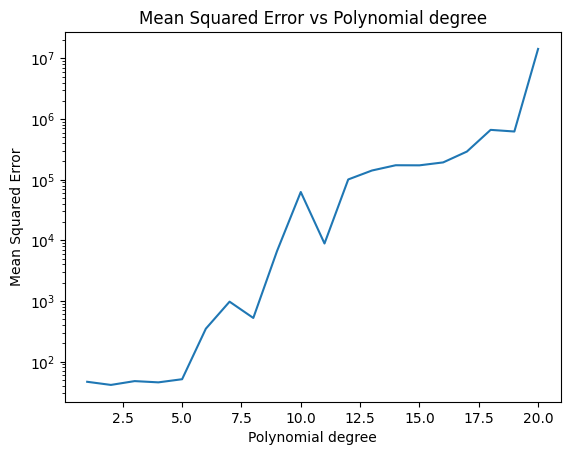

Minimum MSE at degree 2


In [64]:
# Your code here:

# Initialisation
X = data_clean.drop('SSPL', axis=1).to_numpy()
y = data_clean['SSPL'].to_numpy()
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=0)

degree_arr = np.arange(1, 21, 1)
model_arr = np.empty(degree_arr.shape, dtype=object)
mse_arr = np.empty(degree_arr.shape, dtype=object)

# Loop over the different degrees
for i, d in enumerate(degree_arr):
    print(f"{i} out of {len(degree_arr)}")

    # Create the features
    poly = PolynomialFeatures(degree=d)
    poly_X_train = poly.fit_transform(X_train)
    poly_X_cv = poly.fit_transform(X_cv)

    # Initiate and train the model
    model = LinearRegression()
    model.fit(poly_X_train, y_train)
    model_arr[i] = model

    # Test the model on the cv set 
    y_pred = model.predict(poly_X_cv)
    mse_arr[i] = mean_squared_error(y_cv, y_pred)

# Their code for plotting
# Visualize the mean squared error
plt.plot(degree_arr, mse_arr)
plt.yscale('log')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Polynomial degree')
plt.show()

# Visualize a model
degree = 5 # Feel free to change this value to see the effect of the degree on the model

print(f'Minimum MSE at degree {degree_arr[np.argmin(mse_arr)]}')

## Solutions

#### Linear Regression

In [ ]:
import numpy as np

def ordinary_least_squares_method(X, y):
    beta = np.sum((X - np.mean(X)) * (y - np.mean(y)) / np.sum((X - np.mean(X)) ** 2))
    alpha = np.mean(y) - beta * np.mean(X)
    return alpha, beta

#### Multilinear Regression for synthetic data

In [ ]:
intercept = model.intercept_
coefficients = model.coef_
print(f'alpha: {intercept}, beta: {coefficients}')

#### Multilinear Regression for the NACA0012 dataset

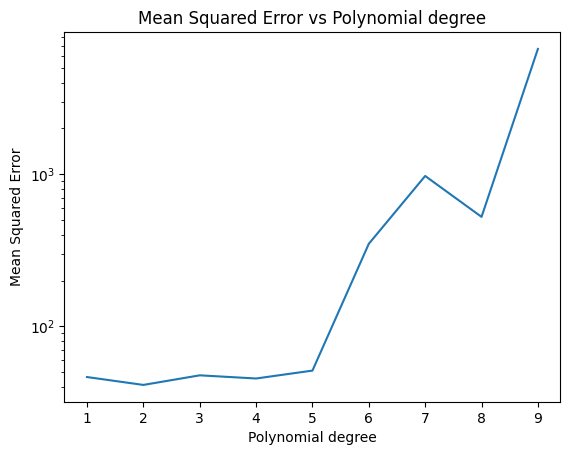

Minimum MSE at degree 2


In [65]:
# Solution
X = data_clean.drop('SSPL', axis=1).to_numpy()
y = data_clean['SSPL'].to_numpy()

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, random_state=0)

degree_list = np.arange(1, 10)
poly_list = np.zeros(len(degree_list), dtype=object)
model_list = np.zeros(len(degree_list), dtype=object)
mse_list = np.zeros(len(degree_list))

for degree in degree_list:
    poly = PolynomialFeatures(degree=degree)
    poly_list[degree-1] = poly
    poly_features = poly.fit_transform(X_train)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)
    model_list[degree-1] = poly_reg_model

    poly_features_cv = poly.fit_transform(X_cv)
    y_pred = poly_reg_model.predict(poly_features_cv)

    mse = mean_squared_error(y_cv, y_pred)
    mse_list[degree-1] = mse

plt.plot(degree_list, mse_list)
plt.yscale('log')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Polynomial degree')
plt.show()

print(f'Minimum MSE at degree {degree_list[np.argmin(mse_list)]}')

In [ ]:
model = model_list[np.argmin(mse_list)]

f = 3500
alpha = 6.7
c = 0.67
U_inifinity = 40
delta = 0.00266337

X_pred = np.array([f, alpha, c, U_inifinity, delta]).reshape(1, -1)
features_pred = poly_list[np.argmin(mse_list)].fit_transform(X_pred)

SSPL = model.predict(features_pred)[0]
SSPL